# Building a table image to .csv pipeline

## Install libraries

In [3]:
%pip install transformers
%pip install pillow huggingface_hub
%pip install timm
%pip install matplotlib

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Table detection

Given a table image and finding the bounding box


In [5]:
# load all the images in the assingment_data directory
import os
from transformers import AutoImageProcessor, TableTransformerForObjectDetection
from PIL import Image

folder_path = '/content/drive/MyDrive/idp_bootcamp/week_3_assignment/assingment_data'

image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

for img_file in image_files:
    print(f"Loaded {img_file}")

Loaded 0005ab896e95c5de6885bbf595500a8e-66.png
Loaded 000f8315c3bea30fb7ae99f925286343-15.png
Loaded 001e626d00966d0268d44ce686e8559b-118.png
Loaded 001e626d00966d0268d44ce686e8559b-62.png
Loaded 0081e7fd154bb0319f96ac0c6127da1a-118.png
Loaded 005608f2ffa46e92e672f0083b6037c4-38.png
Loaded 0079611b26cefff735f1d98a932e8b7d-1.png
Loaded 004f4586092af34f31313224ab19c50c-4.png
Loaded 00c0c202e8d3b133dae5f1e4a7137deb-42.png
Loaded 00bb7f8f05c53d3e4e1ee3f332278707-177.png


In [6]:
#creating new directories to store the outputs
import os
from transformers import AutoImageProcessor, TableTransformerForObjectDetection
from PIL import Image, ImageDraw
import torch

output_bbox_folder = "/content/drive/MyDrive/idp_bootcamp/week_3_assignment/tables_with_bbox"
output_crop_folder = "/content/drive/MyDrive/idp_bootcamp/week_3_assignment/cropped_tables"
table_structure_folder = "/content/drive/MyDrive/idp_bootcamp/week_3_assignment/table_structures"

os.makedirs(output_bbox_folder, exist_ok=True)
os.makedirs(output_crop_folder, exist_ok=True)
os.makedirs(table_structure_folder, exist_ok=True)

In [7]:
# Table detection
image_processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-detection")
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

def visualize_bbox(image, box, color="red", width=2):
    draw = ImageDraw.Draw(image)
    draw.rectangle(box, outline=color, width=width)
    return image

image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mo

In [8]:
# Function to crop out only the tables
def crop_and_save_bounding_boxes(image, boxes, output_folder, image_name):
    """
    Crops the image using the bounding boxes and saves the cropped images.

    Args:
        image: PIL Image object.
        boxes: List of bounding boxes.
        output_folder: Folder path to save cropped images.
        image_name: Base name for cropped image files.
    """
    padding = 10

    for idx, box in enumerate(boxes):

        box = [round(i) for i in box.tolist()]

        box = [box[0] - padding, box[1] - padding, box[2] + padding, box[3] + padding]

        cropped_image = image.crop(box)

        cropped_image.save(os.path.join(output_folder, f"{image_name}.png"))

In [9]:
# Processes all the images and save them in tables_with_bbox, cropped_tables folders respectively
for idx, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path).convert("RGB")

    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]

    image_with_bbox = image.copy()

    if "boxes" in results and len(results["boxes"]) > 0:
        for box in results["boxes"]:
            box = [round(i, 2) for i in box.tolist()]
            image_with_bbox = visualize_bbox(image_with_bbox, box)

        bbox_output_path = os.path.join(output_bbox_folder, image_file)
        image_with_bbox.save(bbox_output_path)
        print(f"Processed and saved bounding box image: {bbox_output_path}")

        crop_and_save_bounding_boxes(image, results["boxes"], output_crop_folder, os.path.splitext(image_file)[0])

    else:
        print(f"No bounding boxes detected for image: {image_file}")

print("All images processed and saved in the respective folders.")

Processed and saved bounding box image: /content/drive/MyDrive/idp_bootcamp/week_3_assignment/tables_with_bbox/0005ab896e95c5de6885bbf595500a8e-66.png
Processed and saved bounding box image: /content/drive/MyDrive/idp_bootcamp/week_3_assignment/tables_with_bbox/000f8315c3bea30fb7ae99f925286343-15.png
Processed and saved bounding box image: /content/drive/MyDrive/idp_bootcamp/week_3_assignment/tables_with_bbox/001e626d00966d0268d44ce686e8559b-118.png
Processed and saved bounding box image: /content/drive/MyDrive/idp_bootcamp/week_3_assignment/tables_with_bbox/001e626d00966d0268d44ce686e8559b-62.png
Processed and saved bounding box image: /content/drive/MyDrive/idp_bootcamp/week_3_assignment/tables_with_bbox/0081e7fd154bb0319f96ac0c6127da1a-118.png
Processed and saved bounding box image: /content/drive/MyDrive/idp_bootcamp/week_3_assignment/tables_with_bbox/005608f2ffa46e92e672f0083b6037c4-38.png
No bounding boxes detected for image: 0079611b26cefff735f1d98a932e8b7d-1.png
Processed and s

Images that does not contain Tables:

	•	00c0c202e8d3b133dae5f1e4a7137deb-42.png
	•	0079611b26cefff735f1d98a932e8b7d-1.png

Images Where the Model Struggles to Detect Table Bounding Boxes:

	•	00bb7f8f05c53d3e4e1ee3f332278707-177.png
	•	001e626d00966d0268d44ce686e8559b-62.png

Images with Successfully Detected Table Bounding Boxes:

	•	0081e7fd154bb0319f96ac0c6127da1a-118.png
	•	0005ab896e95c5de6885bbf595500a8e-66.png
	•	000f8315c3bea30fb7ae99f925286343-15.png
	•	001e626d00966d0268d44ce686e8559b-118.png
	•	004f4586092af34f31313224ab19c50c-4.png
	•	005608f2ffa46e92e672f0083b6037c4-38.png



### Reasons for Inaccurate Bounding Box Detection

  - The absence of visible borders or lines.

  - Images have low resolution.

  - Images with less clear text

  - Complex or Nested Table Structures

  - Unequal Row or Column Sizes

  - Handwritten or Stylized Text

## Table structure recognition


Definition: given a table image, identifying the rows and columns and column headers of the table.

In [10]:
import matplotlib.pyplot as plt
from transformers import DetrFeatureExtractor, DetrForObjectDetection

In [11]:
COLORS = [
    [0.000, 0.447, 0.741],
    [0.850, 0.325, 0.098],
    [0.929, 0.694, 0.125],
    [0.494, 0.184, 0.556],
    [0.466, 0.674, 0.188],
    [0.301, 0.745, 0.933],
]

# # Function to Plot Detected Rows and Columns on Table Image
def plot_simple_box(table_img_path, row_boxes, col_boxes, file_name):
    table_img = Image.open(table_img_path).convert("RGB")
    plt.figure(figsize=(16, 10))
    plt.imshow(table_img)
    ax = plt.gca()
    colors = COLORS * 100

    # Plot row boxes
    for bbox, c in zip(row_boxes, colors):
        ax.add_patch(
            plt.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                fill=False,
                color=c,
                linewidth=1.5,
            )
        )

    plt.axis("off")
    plt.savefig(file_name, bbox_inches="tight", pad_inches=0)
    plt.close()

In [12]:
model_structure = TableTransformerForObjectDetection.from_pretrained(
    "microsoft/table-transformer-structure-recognition")

# Function to Extract Row and Column Bounding Boxes from Table Image
def get_row_col_bounds(table_path, ts_thresh=0.7, plot=False):

    table = Image.open(table_path).convert("RGB")
    feature_extractor = DetrFeatureExtractor()
    table_encoding = feature_extractor(table, return_tensors="pt")

    # predict table structure
    with torch.no_grad():
        outputs = model_structure(**table_encoding)

    # visualize table structure
    target_sizes = [table.size[::-1]]
    table_struct_results = feature_extractor.post_process_object_detection(
        outputs, threshold=ts_thresh, target_sizes=target_sizes
    )[0]


    row_boxes = table_struct_results["boxes"][
        table_struct_results["labels"] == model_structure.config.label2id["table row"]
    ]

    row_scores = table_struct_results["scores"][
        table_struct_results["labels"] == model_structure.config.label2id["table row"]
    ]

    col_boxes = table_struct_results["boxes"][
        table_struct_results["labels"]
        == model_structure.config.label2id["table column"]
    ]

    col_scores = table_struct_results["scores"][
        table_struct_results["labels"]
        == model_structure.config.label2id["table column"]
    ]

    table_header_box = table_struct_results["boxes"][
        table_struct_results["labels"]
        == model_structure.config.label2id["table column header"]
    ]
    table_header_score = table_struct_results["scores"][
        table_struct_results["labels"]
        == model_structure.config.label2id["table column header"]
    ]
    print(os.path.basename(table_path))
    print(f"Num rows initially detected: {len(row_boxes)}")
    print(f"Num cols initially detected: {len(col_boxes)}")
    print(f"Num table header detected: {len(table_header_box)}")


    return (
        row_boxes,
        row_scores,
        col_boxes,
        col_scores,
        table_header_box,
        table_header_score,
    )

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
table_structure_path = "/content/drive/MyDrive/idp_bootcamp/week_3_assignment/table_structures"
os.makedirs(table_structure_path, exist_ok=True)

# loop through each cropped image and detect the table structures
for img_file in os.listdir(output_crop_folder):
    if img_file.endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(output_crop_folder, img_file)

        # Extract row and column boxes
        row_boxes, row_scores, col_boxes, col_scores, header_boxes, header_scores = get_row_col_bounds(img_path)

        # Annotate the image and save the result
        output_path = os.path.join(table_structure_path, img_file)
        plot_simple_box(img_path, row_boxes, col_boxes, output_path)

        print(f"Annotated image saved: {output_path}")

print("All images processed and saved in the 'table_structures' folder.")

0005ab896e95c5de6885bbf595500a8e-66.png
Num rows initially detected: 18
Num cols initially detected: 9
Num table header detected: 1
Annotated image saved: /content/drive/MyDrive/idp_bootcamp/week_3_assignment/table_structures/0005ab896e95c5de6885bbf595500a8e-66.png
000f8315c3bea30fb7ae99f925286343-15.png
Num rows initially detected: 0
Num cols initially detected: 5
Num table header detected: 1
Annotated image saved: /content/drive/MyDrive/idp_bootcamp/week_3_assignment/table_structures/000f8315c3bea30fb7ae99f925286343-15.png
001e626d00966d0268d44ce686e8559b-118.png
Num rows initially detected: 10
Num cols initially detected: 5
Num table header detected: 1
Annotated image saved: /content/drive/MyDrive/idp_bootcamp/week_3_assignment/table_structures/001e626d00966d0268d44ce686e8559b-118.png
001e626d00966d0268d44ce686e8559b-62.png
Num rows initially detected: 17
Num cols initially detected: 2
Num table header detected: 0
Annotated image saved: /content/drive/MyDrive/idp_bootcamp/week_3_ass

### Reasons for Inaccurate table structure detection

  - Two line column name

  - unequal row size

  - The absence of visible borders or lines.

  - Merged Cells

  - Low Image Quality

  - Dense Text Content

  - Non-uniform layouts with inconsistent spacing between rows and columns


In [14]:
table_image_path = "/content/drive/MyDrive/idp_bootcamp/week_3_assignment/table_structures/0081e7fd154bb0319f96ac0c6127da1a-118.png"

In [15]:
# Function to Sort Row and Column Bounding Boxes Based on Their Coordinates
def sort_row_col_boxes(row_boxes, col_boxes):
    row_boxes = row_boxes.tolist()
    col_boxes = col_boxes.tolist()
    row_boxes.sort(key=lambda x: x[1]) #[top_x, top_y, bottom_x, bottom_y]
    col_boxes.sort(key=lambda x: x[0])
    return row_boxes, col_boxes


In [16]:
# Function to Generate Cell Boundaries by Intersecting Row and Column Boxes
def get_cells_by_intersecting_rows_and_cols(row_boxes, col_boxes, padding=(0, 0)):
    cells = []
    for row_box in row_boxes:
        for col_box in col_boxes:
            cell_left_upper_x = col_box[0]
            cell_left_upper_y = row_box[1]
            cell_right_lower_x = col_box[2]
            cell_right_lower_y = row_box[3]
            cells.append(
                [
                    cell_left_upper_x,
                    cell_left_upper_y,
                    cell_right_lower_x,
                    cell_right_lower_y,
                ]
            )
    return cells

In [17]:
table_structure_outs = get_row_col_bounds(table_image_path)

0081e7fd154bb0319f96ac0c6127da1a-118.png
Num rows initially detected: 12
Num cols initially detected: 11
Num table header detected: 1


In [18]:
sorted_rows, sorted_cols = sort_row_col_boxes(table_structure_outs[0], table_structure_outs[2])

In [19]:
cells = get_cells_by_intersecting_rows_and_cols(sorted_rows, sorted_cols)

In [20]:
cells[0]

[21.84713363647461, 59.128108978271484, 259.18212890625, 97.39546966552734]

In [21]:
image = Image.open(table_image_path).convert("RGB")

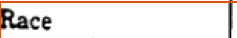

In [22]:
image.crop(cells[0])

## Cells to DataFrame

Now that you have each cell, now we need to get a DataFrame of the table.

In [23]:
%pip install paddlepaddle paddleocr

In [2]:
# PaddleOCR for OCR
from paddleocr import PaddleOCR

ocr = PaddleOCR(
    lang="en",
    use_gpu=False,
    show_log=False,
)

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 4.00M/4.00M [00:00<00:00, 8.30MiB/s]


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10.2M/10.2M [00:00<00:00, 14.3MiB/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:00<00:00, 5.29MiB/s]


In [24]:
%pip install opencv-python

In [25]:
import cv2
import numpy as np

In [26]:
def PIL_to_cv(pil_img):
    return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)


In [28]:
# For each cell OCR
results = []
for cell in cells:
  cell_image = image.crop(cell)
  result = ocr.ocr(PIL_to_cv(cell_image))
  results.append(result)

[2024/10/15 17:26:00] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/10/15 17:26:01] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/10/15 17:26:01] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/10/15 17:26:02] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/10/15 17:26:03] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/10/15 17:26:03] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/10/15 17:26:03] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/10/15 17:26:04] ppocr WARNING: Since the angle classifier is not initialized,

In [31]:
for result in results:
  if result and result[0]:
      print(result[0][0][1][0])
  else:
      continue

Race
Asian
Asian
Asi
ian
Cau
casian
(n=12
Caucass
Number of subjects
12
6
6
6
12
-.
5
Sex
Male
Maie
Female
Fema
e
Fema
Femae
Route of
sc
sc
sc
sc
--
SC
 
sc
1
sc
Daily FSH
225
225
150
300
150
-
150
-.
300
of daily
1/1
1
1/1
1/1
1/1
1/7
1/1
njections/total #
Mean
41.5
32.2
28.9
24.
23.6
26.3
SLadarddevtadon
13.9
4.2
O.
S.3
10.
3.3
Median
40.0
33.2
27.6
24.3
26.
26 
Median absolut.
15.8
8.6
10
8.3
Min
200
25.1
20.9
21.9
8.1
106
226


In [32]:
%pip install pandas

In [33]:
import pandas as pd

In [34]:
num_rows = len(sorted_rows)
num_cols = len(sorted_cols)

df = pd.DataFrame(index=range(num_rows), columns=range(num_cols))

In [36]:
for i, result in enumerate(results):
  if result and result[0] and result[0][0] and result[0][0][1] and result[0][0][1][0]:
      df.iloc[i // num_cols, i % num_cols] = result[0][0][1][0]
  else:
      df.iloc[i // num_cols, i % num_cols] = None

In [37]:
4 % 4

0

In [38]:
df

,0,1,2,3,4,5,6,7,8,9,10
0,Race,Asian,Asian,Asi,ian,None,Cau,casian,(n=12,None,Caucass
1,Number of subjects,12,6,6,6,None,None,12,None,-.,5
2,Sex,Male,Maie,Female,Fema,e,None,Fema,None,None,Femae
3,Route of,sc,sc,sc,sc,--,SC,,sc,1,sc
4,Daily FSH,225,225,150,300,None,150,-,150,-.,300
5,of daily,1/1,1,1/1,1/1,None,1/1,None,1/7,None,1/1
6,njections/total #,None,None,None,None,None,None,None,None,None,None
7,Mean,41.5,32.2,28.9,None,None,24.,None,23.6,None,26.3
8,SLadarddevtadon,13.9,4.2,O.,S.3,None,10.,None,None,None,3.3
9,Median,40.0,33.2,27.6,24.3,None,26.,None,None,None,26


In [39]:
df.iloc[0].tolist()


['Race',
 'Asian',
 'Asian',
 'Asi',
 'ian',
 None,
 'Cau',
 'casian',
 '(n=12',
 None,
 'Caucass']

In [40]:
df.columns = df.iloc[0].tolist()

In [41]:
df.columns

Index([   'Race',   'Asian',   'Asian',     'Asi',     'ian',      None,
           'Cau',  'casian',   '(n=12',      None, 'Caucass'],
      dtype='object')

In [42]:
df = df.iloc[1:]

In [ ]:
df.to_csv("table.csv", index=False)

## Now we can do this for all the images and save the outputs in the csv_out folder

In [44]:
import os
from PIL import Image
import cv2
import numpy as np
import pandas as pd
from paddleocr import PaddleOCR

In [45]:
ocr = PaddleOCR(
    lang="en",
    use_gpu=False,
    show_log=False,
)

In [46]:
# Convert PIL image to OpenCV format
def PIL_to_cv(pil_img):
    return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

In [47]:
# Function to sort row and column boxes
def sort_row_col_boxes(row_boxes, col_boxes):
    row_boxes = row_boxes.tolist()
    col_boxes = col_boxes.tolist()
    row_boxes.sort(key=lambda x: x[1])  # Sort by y-coordinate (top)
    col_boxes.sort(key=lambda x: x[0])  # Sort by x-coordinate (left)
    return row_boxes, col_boxes

In [48]:
# Function to generate cells by intersecting row and column boxes
def get_cells_by_intersecting_rows_and_cols(row_boxes, col_boxes):
    cells = []
    for row_box in row_boxes:
        for col_box in col_boxes:
            cell_left_upper_x = col_box[0]
            cell_left_upper_y = row_box[1]
            cell_right_lower_x = col_box[2]
            cell_right_lower_y = row_box[3]
            cells.append(
                [
                    cell_left_upper_x,
                    cell_left_upper_y,
                    cell_right_lower_x,
                    cell_right_lower_y,
                ]
            )
    return cells

In [49]:
# Folder paths
input_folder = "/content/drive/MyDrive/idp_bootcamp/week_3_assignment/table_structures"
output_folder = "/content/drive/MyDrive/idp_bootcamp/week_3_assignment/csv_outs"
os.makedirs(output_folder, exist_ok=True)

In [50]:
# Process each image in the folder
for img_file in os.listdir(input_folder):
    if img_file.endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(input_folder, img_file)

        # Extract row and column boxes for the table
        row_boxes, row_scores, col_boxes, col_scores, header_boxes, header_scores = get_row_col_bounds(img_path)

        # Sort the rows and columns
        sorted_rows, sorted_cols = sort_row_col_boxes(row_boxes, col_boxes)

        # Get the cell boxes by intersecting row and column boxes
        cells = get_cells_by_intersecting_rows_and_cols(sorted_rows, sorted_cols)

        # Open the image
        image = Image.open(img_path).convert("RGB")

        # Initialize a list to store OCR results
        results = []

        # Perform OCR on each cell
        for cell in cells:
            cell_image = image.crop(cell)
            result = ocr.ocr(PIL_to_cv(cell_image))
            results.append(result)

        # Create a DataFrame for the table
        num_rows = len(sorted_rows)
        num_cols = len(sorted_cols)
        df = pd.DataFrame(index=range(num_rows), columns=range(num_cols))

        # Fill the DataFrame with OCR results
        for i, result in enumerate(results):
            if result and result[0] and result[0][0] and result[0][0][1] and result[0][0][1][0]:
                df.iloc[i // num_cols, i % num_cols] = result[0][0][1][0]
            else:
                df.iloc[i // num_cols, i % num_cols] = None

        # Save the DataFrame as CSV with the same name as the image
        csv_file_name = os.path.splitext(img_file)[0] + ".csv"
        csv_path = os.path.join(output_folder, csv_file_name)
        df.to_csv(csv_path, index=False)

        print(f"Processed and saved table as CSV: {csv_path}")

print("All images processed and saved as CSV files.")

0005ab896e95c5de6885bbf595500a8e-66.png
Num rows initially detected: 17
Num cols initially detected: 6
Num table header detected: 0
[2024/10/15 17:38:05] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/10/15 17:38:06] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/10/15 17:38:06] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/10/15 17:38:06] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/10/15 17:38:06] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/10/15 17:38:06] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/10/15 17:38:06] ppocr WARNING: Since the angle classifier is not initialized

The table detection accuracy is crucial for successful extraction of data from images. Inaccurate table structure detection and boundary detection lead to improper identification of rows, columns, and cells, resulting in incorrect cell cropping. This misalignment causes data loss, as portions of the table content may be excluded or wrongly classified into cells. To resolve this, improving the accuracy of table structure detection would enhance the precision of cell boundary identification. By refining the model’s ability to detect the exact position of rows, columns, and table headers, the output CSV file can be extracted more accurately. Approaches to improve table detection accuracy could include:

    - Using higher resolution images to improve visual clarity.
	- Fine-tuning the model on specific datasets to better understand table formats.
	- Incorporating advanced post-processing techniques to better align detected rows and columns.
	- Adding pre-processing steps to enhance the contrast and edges of table borders for better detection.

With these improvements, the detection model will yield more reliable table structure boundaries, enabling accurate extraction of table data and minimizing data loss.